In [1]:
# Load Some Packages
import numpy as np
import imageio
import scipy as sp
from scipy import signal
import matplotlib.pyplot as plt
import os, glob, ntpath

In [36]:
maxIter = 500

# Given the range of the rectangle
lenX = 250
lenY = 250

deltaX = 1
deltaY = 1
deltaT = 0.1

In [37]:
# Given Some Coefficients in Partial(K)/Partial(t)
D = 0.75

# Given Some Coefficients in F(K)
A = -0.3
Kr = 0.03
Ktheta = 0.2
Km = 1.0

# Given Some Coefficients in Partial(r)/Partial(t)
B = 0.0001
C = 10.0

In [38]:
# Given Initial values
k_init = np.full([lenX, lenY], Kr, dtype=np.float64)
kt_init = np.zeros([lenX, lenY], dtype=np.float64)
r_init = np.zeros([lenX, lenY], dtype=np.float64)
rt_init = np.zeros([lenX, lenY], dtype=np.float64)

In [39]:
# The number of the random points you want to pick
N = 10

# Pick N random point(s) and raise its or them value(s)
for n in range(N):
    a = np.random.randint(0, lenX)
    b = np.random.randint(0, lenY)
    k_init[a, b] = k_init[a, b] + np.random.uniform(0,1-Kr)

In [40]:
# Definie the filter of the laplacian operator
filter_laplacian = np.array([[1/deltaX/deltaY, 1/deltaY**2, 1/deltaX/deltaY],
                           [1/deltaX**2, -4/deltaX/deltaY - 2/deltaX**2 - 2/deltaY**2, 1/deltaX**2],
                           [1/deltaX/deltaY, 1/deltaY**2, 1/deltaX/deltaY]])
filter_laplacian

array([[ 1.,  1.,  1.],
       [ 1., -8.,  1.],
       [ 1.,  1.,  1.]])

In [41]:
def compute_fick_law(boundary, top = 0.0, bottom = 0.0, left = 0.0, right = 0.0):
    
    # remove images
    for image in sorted(glob.glob('./images/*.png'), key=lambda k: int(ntpath.basename(k).replace('.png', ''))):
        os.remove(image)
    
    # Fixed the initial values
    K = k_init
    Kt = kt_init
    R = r_init
    Rt = rt_init
    
    if boundary == 'Diri':
        
        # Fixed the boundary values
        K[:,0] = left
        K[:,-1] = right
        K[0,:] = top
        K[-1,:] = bottom
        
        for i in range(maxIter):
            
            # Fick's second law
            R = R + deltaT*Rt
            Kt = D*sp.signal.convolve2d(K, filter_laplacian, mode = 'same') + A*(K - Kr)*(K - Ktheta)*(K - Km)*(K + 0.1) - R*K
            K = K + deltaT*Kt

            # Fixed the boundary values
            K[:,0] = left
            K[:,-1] = right
            K[0,:] = top
            K[-1,:] = bottom
            
            # plot the images
            plt.imsave('./images/{}.png'.format(i), K, cmap='gray')
            
            # Fick's second law
            Rt = B*((K-Kr) - C*R)
        
    elif boundary == 'Neum':
        
        for i in range(maxIter):
            
            # Fick's second law
            R = R + deltaT*Rt
            
            Kt = sp.signal.convolve2d(K, filter_laplacian, mode = 'same', boundary = 'symm')
            
            # Fixed the differential boundary values
            Kt[:,0] = left
            Kt[:,-1] = right
            Kt[0,:] = top
            Kt[-1,:] = bottom 
            
            Kt = D*Kt + A*(K - Kr)*(K - Ktheta)*(K - Km)*(K + 0.1) - R*K
            K = K + deltaT*Kt
            
            # plot the images
            plt.imsave('./images/{}.png'.format(i), K, cmap='gray')
            
            # Fick's second law
            Rt = B*((K-Kr) - C*R)
        
    elif boundary == 'Perid':
        
        for i in range(maxIter):
            
            # Fick's second law
            R = R + deltaT*Rt
            Kt = D*sp.signal.convolve2d(K, filter_laplacian, mode = 'same', boundary = 'wrap') + A*(K - Kr)*(K - Ktheta)*(K - Km)*(K + 0.1) - R*K
            K = K + deltaT*Kt
            
            # plot the images
            plt.imsave('./images/{}.png'.format(i), K, cmap='gray')
            
            # Fick's second law
            Rt = B*((K-Kr) - C*R)
            

In [45]:
# Diri, Neum, Perid
compute_fick_law('Ne')

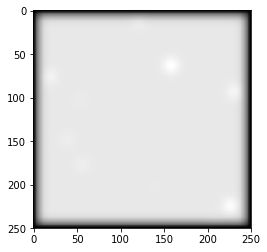

In [46]:
# load all timesteps images
images = []
for image in sorted(glob.glob('./images/*.png'), key=lambda k: int(ntpath.basename(k).replace('.png', ''))):
    images.append(imageio.imread(image))
    
plt.imshow(images[100], cmap='gray')

In [47]:
# compute the gif
imageio.mimsave('images.gif', images)